In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

## Priprava podatkov

In [2]:
df = pd.read_csv('Kickstarter.csv')
del df['Url'], df['BackersNum'], df['Plaged'], df['UpdatesNum'], df['CommentsNum']
df.Location = [x.split("-")[-1] for x in df.Location]
del df["Location"], #df['Month'], df["CDescLength"], df['HasVideo']
df.CampaignYear = df.CampaignYear.astype(str)
df.Subcategory = df.Subcategory.astype(str)

y = np.array(df.pop("Success"))
X = pd.get_dummies(df)
headers = X.columns
X.head()
X = X.values
X = preprocessing.scale(X)
print(X.shape)

(25250, 59)


# Izbira najboljših parametrov

In [5]:
from __future__ import print_function
from sklearn import datasets, cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm

X, X_param, y, y_param = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Set the parameters by cross-validation
lr_params = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100, 250, 500, 750, 1000, 2000]}
rf_params = {'n_estimators': [10, 100, 500, 1000, 2000, 2500, 5000]}
gbc_params = {'n_estimators': [1, 10, 100, 250, 500, 575, 650, 800, 1000]}


# Logistic Regression
clf_lr = GridSearchCV(LogisticRegression(), lr_params, cv=5, scoring="roc_auc")
clf_lr.fit(X_param, y_param)

# Random Forest
clf_rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring="roc_auc")
clf_rf.fit(X_param, y_param)

# Gradient Boosting Classifier
clf_gbc = GridSearchCV(GradientBoostingClassifier(), gbc_params, cv=5, scoring="roc_auc")
clf_gbc.fit(X_param, y_param)


print("Best parameters (LR):", clf_lr.best_params_)
print("Best parameters (RF):", clf_rf.best_params_)
print("Best parameters (GBC):", clf_gbc.best_params_)

Best parameters (LR): {'penalty': 'l1', 'C': 1000}
Best parameters (RF): {'n_estimators': 5000}
Best parameters (GBC): {'n_estimators': 250}


# Testiranje rezultatov

In [16]:
from sklearn import metrics 

print(X.shape)

models = {'LR': LogisticRegression(**clf_lr.best_params_), 
          'RF': RandomForestClassifier(**clf_rf.best_params_), 
          'GBC': GradientBoostingClassifier(**clf_gbc.best_params_)}

results = {'LR': {}, 'RF': {}, 'GBC': {}}

kf_total = cross_validation.KFold(len(X), n_folds=10, shuffle=True, random_state=42)
for train, test in kf_total:
    for key in models:
        models[key].fit(X[train], y[train])
    
        results[key].setdefault('F1', []) 
        results[key].setdefault('AUC', [])
        results[key].setdefault('CA', [])
        ypred = models[key].predict(X[test])
        ypred_prob = models[key].predict_proba(X[test])[:, 1]
        
        # F1
        results[key]['F1'].append(metrics.f1_score(y[test], ypred))
        
        # AUC
        fpr, tpr, thresholds = metrics.roc_curve(y[test], ypred_prob, pos_label=1)
        results[key]['AUC'].append(metrics.auc(fpr, tpr))
        
        # CA
        results[key]['CA'].append(metrics.accuracy_score(y[test], ypred))
        
print('\t F1\t     AUC\tCA')
for key in results:
    print(key, "\t", "{:.3f}".format(np.mean(results[key]['F1'])), "     ", 
          "{:.3f}".format(np.mean(results[key]['AUC'])), "     ",
          "{:.3f}".format(np.mean(results[key]['CA'])))

(18957, 47)
	 F1	     AUC	CA
RF 	 0.822       0.854       0.873
LR 	 0.786       0.826       0.854
GBC 	 0.825       0.856       0.875


'Brez location in obični attr'

### Površine pod krivuljo ROC

(20200, 59)


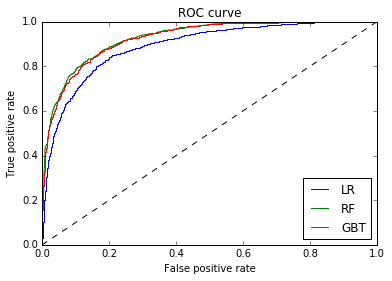

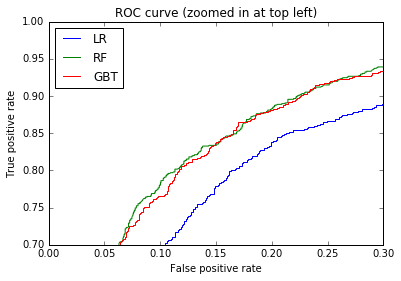

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(X.shape)

# The logistic regression model by itself
lr = LogisticRegression(**clf_lr.best_params_)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

# The gradient boosted model by itself
grd = GradientBoostingClassifier(**clf_gbc.best_params_)
grd.fit(X_train, y_train)
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)


# The random forest model by itself
rf = RandomForestClassifier(**clf_rf.best_params_)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
        
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# Metoda stacking
Testiranje rezultatov pri metodi stacking

In [4]:
import numpy as np
import Orange as org
import Orange
import Orange.regression
import Orange.classification
from Orange.classification import LogisticRegressionLearner
from Orange.classification import Model
from Orange.regression import LinearRegressionLearner
from Orange.evaluation import CrossValidation
from Orange.data import Table, Domain, ContinuousVariable
from sklearn import preprocessing
from sklearn import metrics 

class StackedClassificationLearner(Orange.classification.Learner):

    def __init__(self, learners, meta_learner=LogisticRegressionLearner, k=5):
        super().__init__()
        self.k = k  # number of internal cross-validations
        self.learners = learners
        self.meta_learner = meta_learner  # base learner
        self.name = "stacking"

    def fit_storage(self, data):
        """Return a stacked model inferred from the training set."""
        n = len(data.domain.class_var.values)
        features = [ContinuousVariable("F%d" % i)
                    for i in range(len(self.learners) * (n - 1))]
        domain = Domain(features, data.domain.class_var)
        kf_total = cross_validation.KFold(len(data.X), n_folds=5)
        p_data = y = None
        for train, test in kf_total:
            for learner in self.learners:
                learner.fit(data.X[train], data.Y[train])
            if p_data is None:
                p_data =  np.hstack(learner.predict_proba(data.X[test])[:, :-1] for learner in self.learners)
                y = np.array(data.Y[test])
            else:
                p_data = np.append(p_data, np.hstack(learner.predict_proba(data.X[test])[:, :-1] for learner in self.learners), axis=0)
                y = np.append(y, data.Y[test])
        #print(p_data[:5])
        meta_data = Table(domain, p_data, y)
        meta_model = self.meta_learner(meta_data)
        models = [learner.fit(data.X, data.Y) for learner in self.learners]
        return StackedClassificationModel(data.domain, Domain(features),
                                          models, meta_model, name=self.name)

class StackedClassificationModel(Orange.classification.Model):
    """
    Stacked classifier.
    """
    def __init__(self, domain, meta_domain, models,
                 meta_model, name="stacking"):
        super().__init__(domain)
        self.models = models  # a list of predictors
        self.meta_model = meta_model
        self.meta_domain = meta_domain
        self.name = name

    def predict_storage(self, data):
        """Given a data table returns predicted class."""
        x = np.hstack(model.predict_proba(data.X)[:, :-1] for model in self.models)
        #print("x:", x[:5])
        #print(self.meta_domain, Model.ValueProbs)
        data = Table(self.meta_domain, x)
        return self.meta_model(data, Model.ValueProbs)

In [9]:
result_f1 = []
result_auc = []
result_ca = []
y_test = y_pred = []
from sklearn.ensemble import ExtraTreesClassifier
data = org.data.Table("attr.csv")
models = [RandomForestClassifier(**clf_rf.best_params_),
          LogisticRegression(**clf_lr.best_params_),
          GradientBoostingClassifier(**clf_gbc.best_params_)]

print(X.shape)
kf_total = cross_validation.KFold(len(X), n_folds=10, shuffle=True, random_state=42)
for train, test in kf_total:
    data.X = X[train]
    data.Y = y[train]

    # initialize multi-stage model
    scl = StackedClassificationLearner(models)

    # fit model
    scm = scl.fit_storage(data)

    data.X = X[test]
    data.Y = y[test]
    ypred = scm.predict_storage(data)
    
    y_test.append(y[test])
    y_pred.append(ypred)

    # F1
    result_f1.append(metrics.f1_score(y[test], ypred[0]))

    # AUC
    fpr, tpr, thresholds = metrics.roc_curve(y[test], ypred[1][:, 1], pos_label=1)
    result_auc.append(metrics.auc(fpr, tpr))
    
    result_ca.append(metrics.accuracy_score(y[test], ypred[0]))
        
print('\t\t F1\t    AUC     CA')
print("Stacking\t", "{:.3f}".format(np.mean(result_f1)), "     ", 
          "{:.3f}".format(np.mean(result_auc)), "     ", 
          "{:.3f}".format(np.mean(result_ca)))

(20200, 59)
		 F1	    AUC     CA
Stacking	 0.770       0.922       0.846


# Analiza napačnih napovedi
Analiza primerov, ki smo jim pri metodi stacking napačno napovedali razred.

In [10]:
a = [x for x in y_pred if len(x) == 2]

In [11]:
y_pred = np.array([])
y_p = np.array([])
for x,p in a:
    y_pred = np.concatenate((y_pred, x), axis=0)
    if len(y_p) == 0:
        y_p = p
        continue
    y_p = np.concatenate((y_p, p), axis=0)

In [12]:
y_test = np.array([])
t = np.array([])
kf_total = cross_validation.KFold(len(X), n_folds=10, shuffle=True, random_state=42)
for train, test in kf_total:
    t = np.concatenate((t, test), axis=0)
    y_test = np.concatenate((y_test, y[test]), axis=0)

In [22]:
i = ine = ipo = fn = fp = 0
indexes_n = []
indexes_p = []
fn_pr = []
fp_pr = []
for yt, yp in zip(y_test, y_pred):
    if(yt != yp):
        indexes_n.append(i)
        if(yt == 1):
            fn +=  y_p[i][1]
            fn_pr.append(y_p[i][1])
            ine += 1
        elif(yt == 0):
            fp +=  y_p[i][1]
            fp_pr.append(y_p[i][1])
            ipo += 1
    else:
        indexes_p.append(i)
            

    i += 1
    
print(ipo, fp/ipo)
print(ine, fn/ine)
print(len(y_test))

1309 0.708699593975
1793 0.257489069225
20200


In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[11906,  1309],
       [ 1793,  5192]])

### Vrednosti atributov pri napačnih napovedih
Sprva so podatki primerov, ki smo jih napačno klasificirali in nato tisti, ki smo jih pravilno.

In [27]:
t = t.astype(int)

df = pd.read_csv('Kickstarter.csv')
del df['Url'], df['BackersNum'], df['Plaged'], df['UpdatesNum'], df['CommentsNum']
#df.Location = [x.split("-")[-1] for x in df.Location]
del df["Location"], #df['Month'], df["CDescLength"], df['HasVideo']
df.CampaignYear = df.CampaignYear.astype(str)
df.Subcategory = df.Subcategory.astype(str)


yt = np.array(df.pop("Success"))
Xt = pd.get_dummies(df)
Xt = Xt.values
Xt, _, yt, _ = train_test_split(Xt, yt, test_size=0.2, random_state=42)

Xt = Xt[t[indexes_n]]
print(len(t[indexes_n]))
subcat = {}
for i in range(len(headers)):
    avrg = sum([x[i] for x in Xt])/Xt.shape[0]
    print(i, ". ", headers[i], ": ", "{:.2f}".format(avrg))
    subcat[headers[i].split("_")[-1]] = avrg

3102
0 .  FbConnection :  0.53
1 .  BackedProj :  4.73
2 .  CreatedProj :  0.91
3 .  CDescLength :  371.58
4 .  TitleLength :  39.58
5 .  Goal :  20034.43
6 .  Duration :  32.41
7 .  RewardsNum :  9.33
8 .  MinPledgeTiers :  10.82
9 .  MaxPledgeTiers :  2259.25
10 .  CharactersNum :  5802.35
11 .  PucturesNum :  11.18
12 .  VideosNum :  1.09
13 .  HasVideo :  0.82
14 .  CampaignYear_2014 :  0.35
15 .  CampaignYear_2015 :  0.56
16 .  CampaignYear_2016 :  0.08
17 .  Month_Apr :  0.08
18 .  Month_Aug :  0.08
19 .  Month_Dec :  0.07
20 .  Month_Feb :  0.08
21 .  Month_Jan :  0.08
22 .  Month_Jul :  0.08
23 .  Month_Jun :  0.09
24 .  Month_Mar :  0.09
25 .  Month_May :  0.08
26 .  Month_Nov :  0.10
27 .  Month_Oct :  0.08
28 .  Month_Sep :  0.08
29 .  Subcategory_20 :  0.01
30 .  Subcategory_21 :  0.01
31 .  Subcategory_22 :  0.04
32 .  Subcategory_23 :  0.04
33 .  Subcategory_24 :  0.02
34 .  Subcategory_25 :  0.01
35 .  Subcategory_26 :  0.07
36 .  Subcategory_27 :  0.03
37 .  Subcategory

In [26]:
t = t.astype(int)

df = pd.read_csv('Kickstarter.csv')
del df['Url'], df['BackersNum'], df['Plaged'], df['UpdatesNum'], df['CommentsNum']
#df.Location = [x.split("-")[-1] for x in df.Location]
del df["Location"], #df['Month'], df["CDescLength"], df['HasVideo']
df.CampaignYear = df.CampaignYear.astype(str)
df.Subcategory = df.Subcategory.astype(str)


yt = np.array(df.pop("Success"))
Xt = pd.get_dummies(df)
Xt = Xt.values
Xt, _, yt, _ = train_test_split(Xt, yt, test_size=0.2, random_state=42)


Xt = Xt[t[indexes_p]]
print(len(t[indexes_p]))
subcat = {}
for i in range(len(headers)):
    avrg = sum([x[i] for x in Xt])/Xt.shape[0]
    print(i, ". ", headers[i], ": ", "{:.2f}".format(avrg))
    subcat[headers[i].split("_")[-1]] = avrg

20200
0 .  FbConnection :  0.52
1 .  BackedProj :  5.47
2 .  CreatedProj :  1.18
3 .  CDescLength :  362.70
4 .  TitleLength :  36.38
5 .  Goal :  64292.60
6 .  Duration :  33.52
7 .  RewardsNum :  7.52
8 .  MinPledgeTiers :  52.09
9 .  MaxPledgeTiers :  1841.14
10 .  CharactersNum :  4889.40
11 .  PucturesNum :  8.40
12 .  VideosNum :  0.88
13 .  HasVideo :  0.68
14 .  CampaignYear_2014 :  0.36
15 .  CampaignYear_2015 :  0.54
16 .  CampaignYear_2016 :  0.10
17 .  Month_Apr :  0.07
18 .  Month_Aug :  0.08
19 .  Month_Dec :  0.08
20 .  Month_Feb :  0.10
21 .  Month_Jan :  0.09
22 .  Month_Jul :  0.09
23 .  Month_Jun :  0.08
24 .  Month_Mar :  0.08
25 .  Month_May :  0.07
26 .  Month_Nov :  0.09
27 .  Month_Oct :  0.09
28 .  Month_Sep :  0.08
29 .  Subcategory_20 :  0.01
30 .  Subcategory_21 :  0.01
31 .  Subcategory_22 :  0.02
32 .  Subcategory_23 :  0.03
33 .  Subcategory_24 :  0.01
34 .  Subcategory_25 :  0.01
35 .  Subcategory_26 :  0.07
36 .  Subcategory_27 :  0.02
37 .  Subcategory

### Kategorije projekta
Število napačnih napovedi po kategorijah

In [28]:
df = pd.read_csv('Kickstarter.csv')
del df['Url'], df['BackersNum'], df['Plaged'], df['UpdatesNum'], df['CommentsNum']
#df.Location = [x.split("-")[-1] for x in df.Location]
del df["Location"], #df['Month'], df["CDescLength"], df['HasVideo']
df.CampaignYear = df.CampaignYear.astype(str)
df.Subcategory = df.Subcategory.astype(str)

In [30]:
import urllib.parse
import urllib.request
import re
categories = [i for i in range(331,343)] + [51, 52, 362] + [i for i in range(21,35)]
for c in categories:
    #try:
    url = 'https://www.kickstarter.com/discover/advanced?'
    values = {'category_id' : c, 'woe_id': '0', 'sort': 'end_date', 'seed' : '2431954', 'page': 1}
    data = urllib.parse.urlencode(values)
    reqUrl = url + str(data)
    req = urllib.request.Request(reqUrl)
    resp = urllib.request.urlopen(req)
    respData = resp.read()
    categoriy = re.findall(r'class="category">live (.*?) projects', str(respData))[0]
    if len(df[df.Subcategory == str(c)]) >= 400:
        print(categoriy, "& ", len(df[df.Subcategory == str(c)]), "&", "{:.0f}".format(subcat[str(c)]*len(t[indexes_n])),
      "&", "{:.2f}".format(subcat[str(c)]*len(t[indexes_n])/len(df[df.Subcategory == str(c)])), " \\\\")
    #except Exception as e:
        #continue
    

Apps &  3018 & 136 & 0.05  \\
DIY Electronics &  414 & 75 & 0.18  \\
Gadgets &  1447 & 213 & 0.15  \\
Wearables &  614 & 112 & 0.18  \\
Web &  2460 & 127 & 0.05  \\
Software &  1463 & 96 & 0.07  \\
Hardware &  1666 & 289 & 0.17  \\
Illustration &  589 & 119 & 0.20  \\
Painting &  662 & 115 & 0.17  \\
Crafts &  1663 & 215 & 0.13  \\
Product Design &  2221 & 267 & 0.12  \\
Animation &  433 & 70 & 0.16  \\
Documentary &  1570 & 230 & 0.15  \\
Narrative Film &  474 & 112 & 0.24  \\
Shorts &  862 & 70 & 0.08  \\
Webseries &  807 & 138 & 0.17  \\
Tabletop Games &  1559 & 109 & 0.07  \\


### Napovedovanje FP in FN - verjetnosti

#### Napačneo negativne napovedi:

0.257489069225 0.137894671668


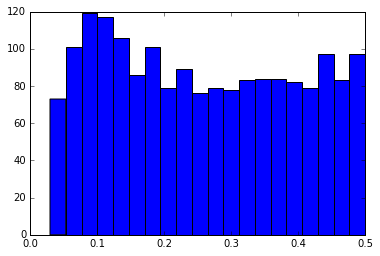

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

mu = np.average(fn_pr)
sigma = np.std(np.array(fn_pr))

print(mu, sigma)

count, bins, ignored = plt.hist(fn_pr, 20)
#plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2)), linewidth=2, color='r')
plt.show()

##### Napačneo pozitivne napovedi:

0.708699593975 0.130696446951


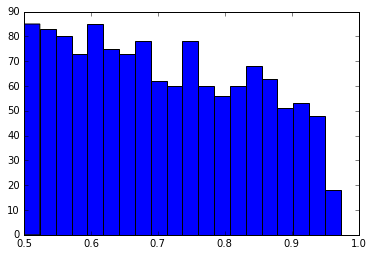

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

mu = np.average(fp_pr)
sigma = np.std(np.array(fp_pr))

print(mu, sigma)

count, bins, ignored = plt.hist(fp_pr, 20)
#plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2)), linewidth=2, color='r')
plt.show()